In [51]:
import kagglehub
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [52]:
# Enable GPU
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 1


In [53]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [54]:
# Download latest version
dataset_path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


(194, 259, 3)
(225, 225, 3)
(225, 225, 3)
(190, 266, 3)
(194, 259, 3)
(201, 251, 3)


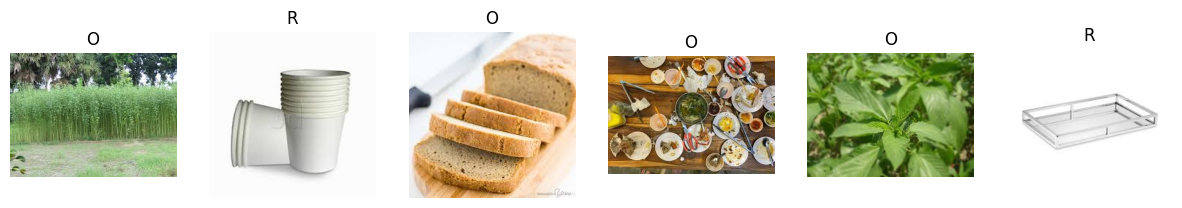

In [55]:
# Display some random images
categories = os.listdir(os.path.join(dataset_path, 'DATASET/TRAIN'))
num_samples = 6
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(num_samples):
    category = random.choice(categories)
    img_name = random.choice(os.listdir(os.path.join(dataset_path, 'DATASET/TRAIN', category)))
    img_path = os.path.join(dataset_path, 'DATASET/TRAIN', category, img_name)
    img = plt.imread(img_path)
    print(img.shape)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')
plt.show()


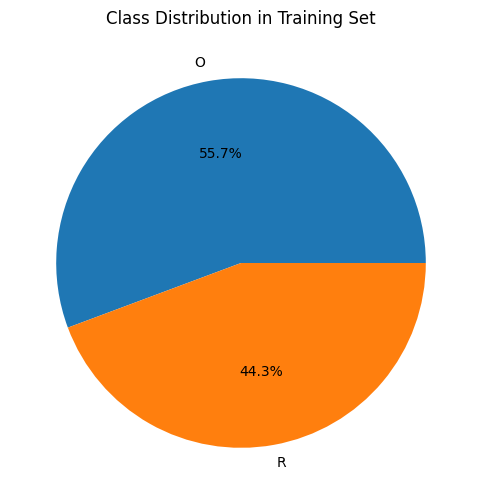

In [56]:
# Function to count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in train and test directories
train_counts = count_images(os.path.join(dataset_path, 'DATASET/TRAIN'))
test_counts = count_images(os.path.join(dataset_path, 'DATASET/TEST'))

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', startangle=0)
plt.title("Class Distribution in Training Set")
plt.show()


In [57]:
# Data Preprocessing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [58]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'DATASET/TRAIN'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')
val_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'DATASET/TRAIN'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'DATASET/TEST'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [59]:
# Define CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer=GlorotUniform()),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint callback
checkpoint_callback = ModelCheckpoint(
    "best_model.h5",  # Save the best model
    monitor="val_loss",  # Track validation loss
    save_best_only=True,  # Save only if validation loss improves
    mode="min",  # Lower validation loss is better
    verbose=1
)

In [62]:
# Train Model
epochs = 10

# Train Model on GPU
with tf.device('/GPU:0'):
    history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[checkpoint_callback])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


564/565 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7447 - loss: 0.6086
Epoch 1: val_loss improved from inf to 0.43809, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - accuracy: 0.7449 - loss: 0.6081 - val_accuracy: 0.8083 - val_loss: 0.4381
Epoch 2/10
564/565 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8456 - loss: 0.3755
Epoch 2: val_loss improved from 0.43809 to 0.37959, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - accuracy: 0.8456 - loss: 0.3755 - val_accuracy: 0.8378 - val_loss: 0.3796
Epoch 3/10
564/565 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8617 - loss: 0.3354
Epoch 3: val_loss did not improve from 0.37959
565/565 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.8617 - loss: 0.3354 - val_accuracy: 0.8112 - val_loss: 0.4033
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8669 - loss: 0.3217
Epoch 4: val_loss improved from 0.37959 to 0.37739, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.8669 - loss: 0.3217 - val_accuracy: 0.8506 - val_loss: 0.3774
Epoch 5/10
564/565 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8850 - loss: 0.2856
Epoch 5: val_loss did not improve from 0.37739
565/565 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.8850 - loss: 0.2856 - val_accuracy: 0.8245 - val_loss: 0.4035
Epoch 6/10
564/565 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9068 - loss: 0.2343
Epoch 6: val_loss did not improve from 0.37739
565/565 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - accuracy: 0.9068 - loss: 0.2344 - val_accuracy: 0.8347 - val_loss: 0.4350
Epoch 7/10
564/565 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9244 - loss: 0.1894
Epoch 7: val_loss did not improve from 0.37739
565/565 ━━━━━━━━━━━━━━━━━━━━ 34s 60ms/step - accuracy: 0.9244 - loss: 0.1894 - val_accuracy: 0.8380 - val_loss: 0.4399
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9439 - loss: 0.1414
Epoch 8: val_loss did not improve f

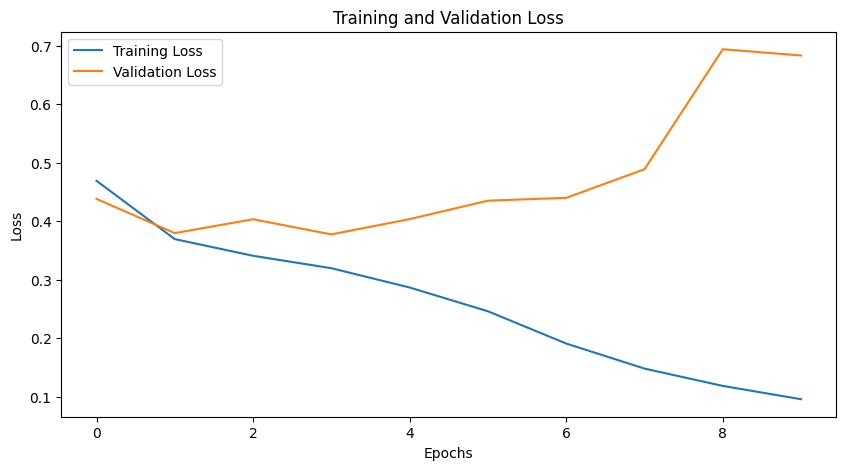

In [63]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [64]:
# Evaluate model on test set
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


In [65]:
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
               precision    recall  f1-score   support

           O       0.86      0.97      0.91      1401
           R       0.96      0.80      0.87      1112

    accuracy                           0.90      2513
   macro avg       0.91      0.89      0.89      2513
weighted avg       0.90      0.90      0.90      2513



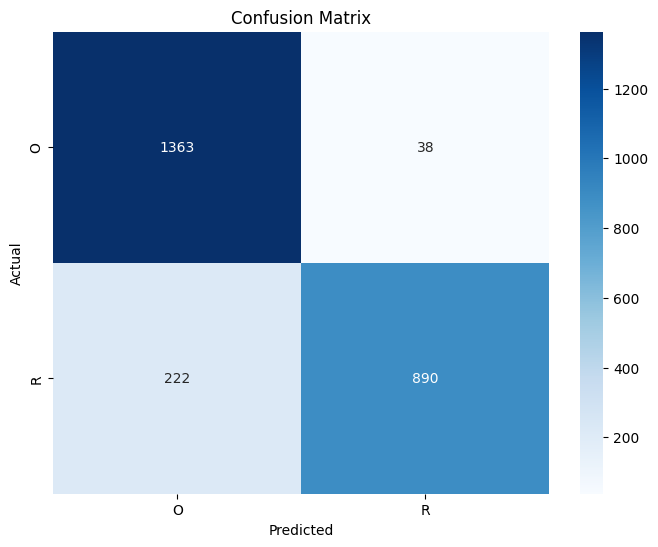

In [66]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()